# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

## Подготовка данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None
import phik
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
import os
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [6]:
pth1 = 'autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [7]:
df_full = df.copy()

In [8]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проведем первичный осмотр данных и выявим их проблемы.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [10]:
# Проверим дубликаты
df.duplicated().sum()

4

In [11]:
#Удалим их
df = df.drop_duplicates()

In [12]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [13]:
# посмотрим на пропуски
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
Repaired             0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

**Вывод:**

- В данных присутсвуют лишнии колонки
- Были удалены дубликаты
- Необходима обработка пропусков

**Предобработка данных**

Удалим лишнии колонки

In [14]:
df= df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns')

In [15]:
# Переведем колонки в нижний регистр
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354365 non-null  int64 
 1   vehicletype       316875 non-null  object
 2   registrationyear  354365 non-null  int64 
 3   gearbox           334532 non-null  object
 4   power             354365 non-null  int64 
 5   model             334660 non-null  object
 6   kilometer         354365 non-null  int64 
 7   fueltype          321470 non-null  object
 8   brand             354365 non-null  object
 9   repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


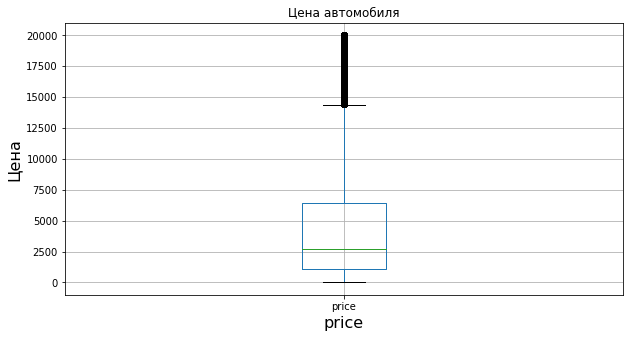

In [16]:
df.boxplot('price')
plt.xlabel('price', fontsize=16)
plt.ylabel(r'Цена', fontsize=16)
plt.title(r'Цена автомобиля');

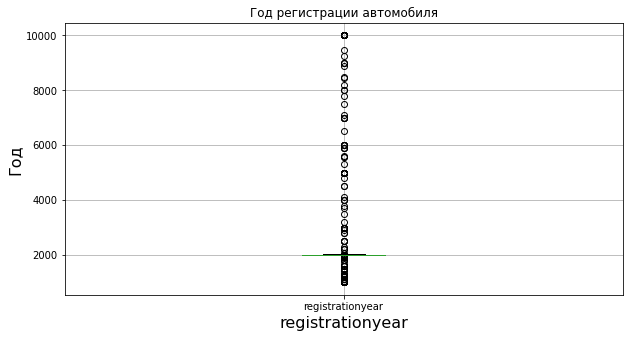

In [17]:
df.boxplot('registrationyear')
plt.xlabel('registrationyear', fontsize=16)
plt.ylabel(r'Год', fontsize=16)
plt.title(r'Год регистрации автомобиля');

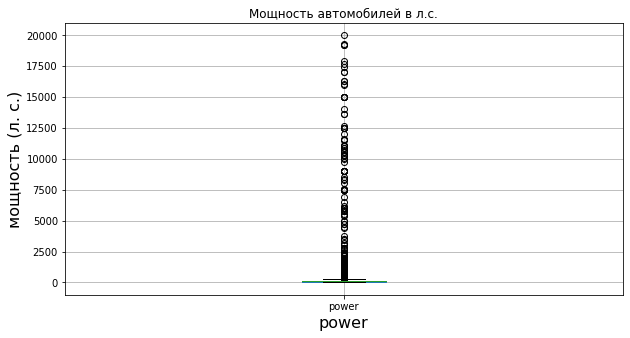

In [18]:
df.boxplot('power')
plt.xlabel('power', fontsize=16)
plt.ylabel(r'мощность (л. с.)', fontsize=16)
plt.title(r'Мощность автомобилей в л.с.');

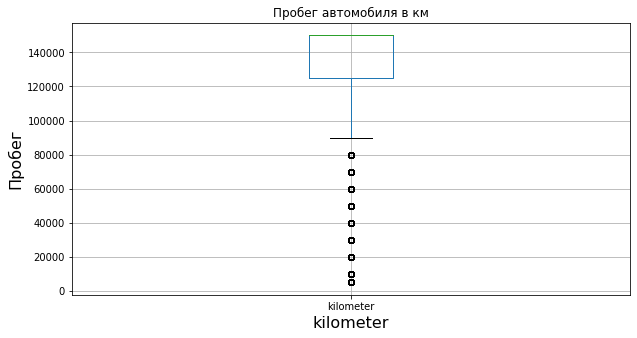

In [19]:
df.boxplot('kilometer')
plt.xlabel('kilometer', fontsize=16)
plt.ylabel(r'Пробег', fontsize=16)
plt.title(r'Пробег автомобиля в км');

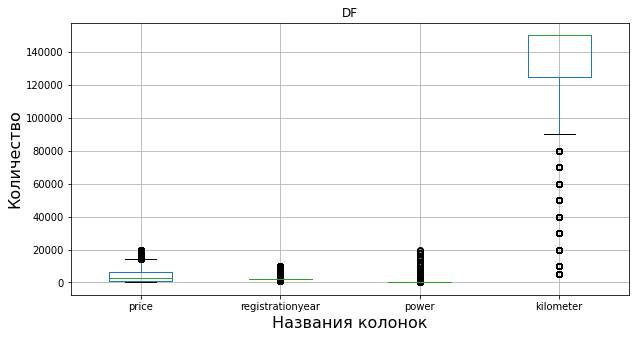

In [20]:
df.boxplot()
plt.xlabel('Названия колонок', fontsize=16)
plt.ylabel(r'Количество', fontsize=16)
plt.title(r'DF');

Становитсья видно что в данных много выбросов, необходимо рассмотреть по подробнее некоторые важные колонки.

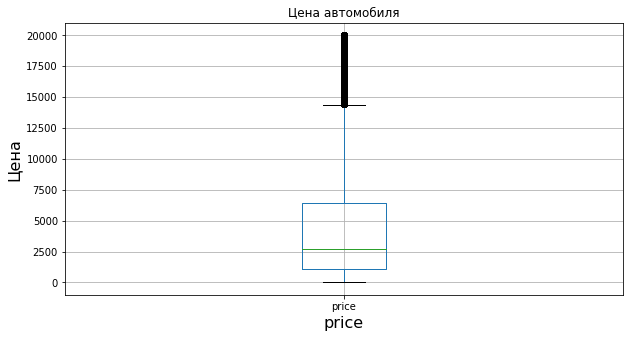

In [21]:
df.boxplot('price')
plt.xlabel('price', fontsize=16)
plt.ylabel(r'Цена', fontsize=16)
plt.title(r'Цена автомобиля');

Цена на автомобиль не может быть нулевая, очистим данные от них.

In [22]:
df = df.query('price > 1000')

Посмотрим на колонку **power**

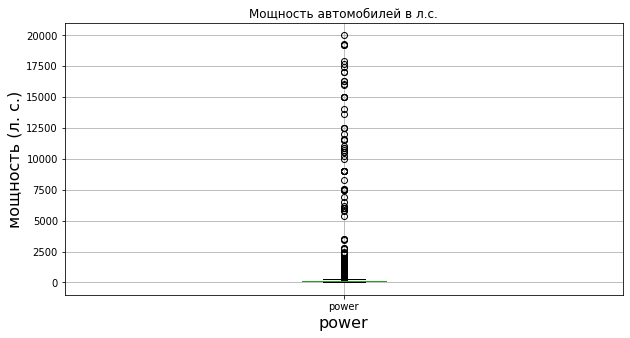

In [23]:
df.boxplot('power')
plt.xlabel('power', fontsize=16)
plt.ylabel(r'мощность (л. с.)', fontsize=16)
plt.title(r'Мощность автомобилей в л.с.');

В данных очень сильные выбросы, проанализируем представленные бренды автомобилей и постараемся выявить границу реальных данных по мощности.

<AxesSubplot:>

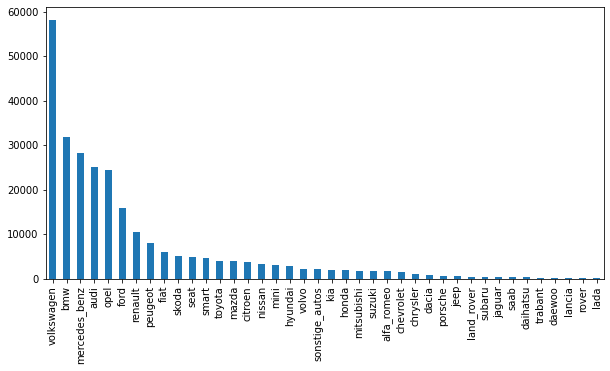

In [24]:
ax = df['brand'].value_counts()
ax.plot(kind='bar')

В брендах отсутствуют громкие названия гиперкаров по типу Buggati имеющие более 1000л\с а значит что значения мошности сильно завышены.

Мощность серийных автомобилей очень редко превышает 600 л\с, возьмем эту цифру за верхнюю границу, ну и машин с 0 мошностью не бывает.

In [25]:
df = df.query('power > 50 and power < 600')

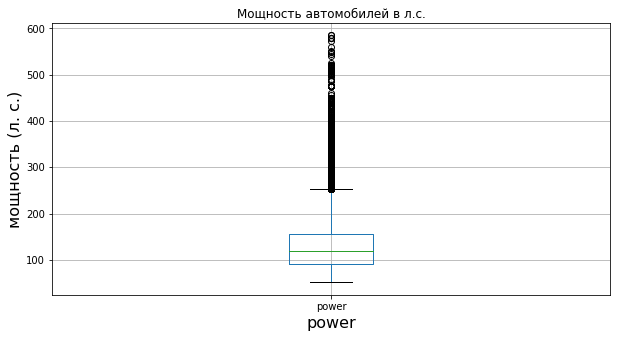

In [26]:
df.boxplot('power')
plt.xlabel('power', fontsize=16)
plt.ylabel(r'мощность (л. с.)', fontsize=16)
plt.title(r'Мощность автомобилей в л.с.');

Взгляним на признак **registrationyear**

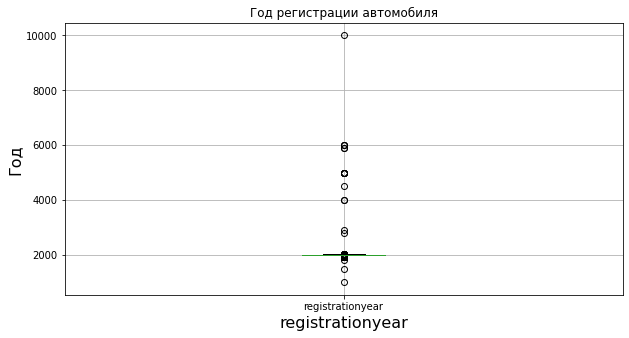

In [27]:
df.boxplot('registrationyear')
plt.xlabel('registrationyear', fontsize=16)
plt.ylabel(r'Год', fontsize=16)
plt.title(r'Год регистрации автомобиля');

Так же можем наблюдать не верные данные.

In [28]:
df = df.query('registrationyear > 1980 and registrationyear < 2016')

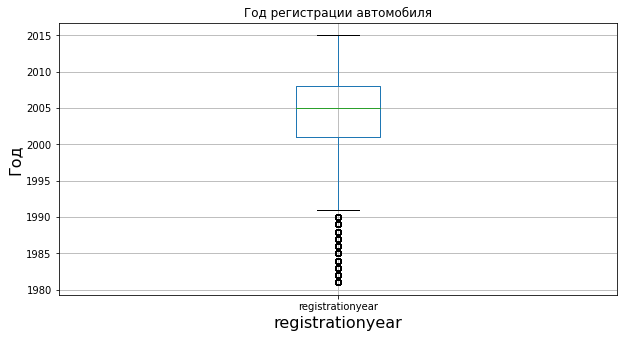

In [29]:
# Посмотрим еще раз.
df.boxplot('registrationyear')
plt.xlabel('registrationyear', fontsize=16)
plt.ylabel(r'Год', fontsize=16)
plt.title(r'Год регистрации автомобиля');

In [30]:
df['repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

Заполним пропуски в колонке **notrepaired** нулем 0 так как скорее всего при заполнении данных этот пункт пропускался из-за отсутсвия ремонта.

In [31]:
df['repaired'] = df['repaired'].fillna('no')

In [32]:
df['repaired'].unique()

array(['yes', 'no'], dtype=object)

In [33]:
df1 = df.copy()

In [34]:
# Взгляним еще раз на пропуски.
df.isna().mean()

price               0.000000
vehicletype         0.010481
registrationyear    0.000000
gearbox             0.012795
power               0.000000
model               0.028038
kilometer           0.000000
fueltype            0.032699
brand               0.000000
repaired            0.000000
dtype: float64

In [35]:
df['vehicletype'].unique()

array(['coupe', 'suv', 'small', 'convertible', 'bus', 'sedan', 'wagon',
       'other', nan], dtype=object)

In [36]:
df['vehicletype'] = df['vehicletype'].fillna('unknown')

In [37]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [38]:
df['gearbox'] = df['gearbox'].fillna('unknown')

In [39]:
df['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'twingo', 'a_klasse', 'scirocco', '5er',
       'civic', 'e_klasse', '3er', 'kadett', 'other', 'one', 'fortwo',
       '1er', 'b_klasse', 'a8', 'jetta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'forester', 'xc_reihe', 'fiesta', 'scenic', 'a1',
       'transporter', 'focus', 'a4', 'tt', 'astra', 'a6', 'jazz', 'polo',
       'slk', '7er', 'combo', '80', '147', 'z_reihe', 'sorento', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'insignia', 'ka', 'megane',
       'a3', 'cordoba', 'clio', 'impreza', 'lupo', 'berlingo', 'tiguan',
       '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', 'corsa', '6er',
       'punto', 'fox', 'vectra', 'matiz', 'beetle', 'rio', 'touareg',
       'logan', 'spider', 'cuore', 's_max', 'modus', 'a2', 'galaxy', 'c3',
       'viano', 's_klasse', 'mondeo', 'sharan', 'avensis', 'roomster',
     

In [40]:
df['model'] = df['model'].fillna('unknown')

In [41]:
df['fueltype'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [42]:
df['fueltype'] = df['fueltype'].fillna('unknown')

In [43]:
df.isna().mean()

price               0.0
vehicletype         0.0
registrationyear    0.0
gearbox             0.0
power               0.0
model               0.0
kilometer           0.0
fueltype            0.0
brand               0.0
repaired            0.0
dtype: float64

In [44]:
df.dtypes

price                int64
vehicletype         object
registrationyear     int64
gearbox             object
power                int64
model               object
kilometer            int64
fueltype            object
brand               object
repaired            object
dtype: object

Пропусков ~ 5% считаю это не значительным числом и просто удалю оставшиеся пропуски.

In [45]:
print('Из первоначальной базы данных понадобилась убрать {0:.1f}% данных'.format((len(df_full) - len(df1)) / (len(df_full)/100)))

Из первоначальной базы данных понадобилась убрать 35.5% данных


In [46]:
print('Из первоначальной базы данных понадобилась убрать {0:.1f}% данных'.format((len(df_full) - len(df)) / (len(df_full)/100)))

Из первоначальной базы данных понадобилась убрать 35.5% данных


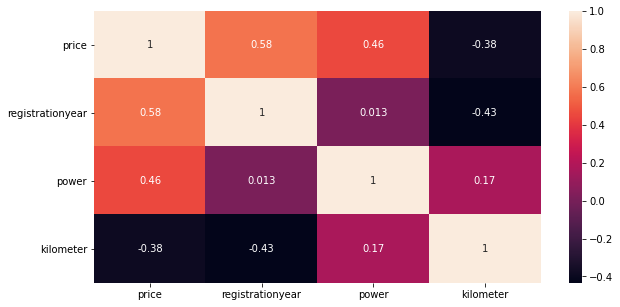

In [47]:
sns.heatmap(df.corr(),annot = True);

In [48]:
df.phik_matrix(interval_cols=['price', 'power'])

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
price,1.000000,0.216127,0.625108,0.263669,0.462004,0.531019,0.315369,0.193937,0.312743,0.166767
vehicletype,0.216127,1.000000,0.289321,0.363072,0.439331,0.908618,0.234938,0.363412,0.606058,0.040844
registrationyear,0.625108,0.289321,1.000000,0.092614,0.181113,0.637221,0.634197,0.286077,0.289351,0.057610
gearbox,0.263669,0.363072,0.092614,1.000000,0.470531,0.633592,0.085787,0.183834,0.520747,0.005158
power,0.462004,0.439331,0.181113,0.470531,1.000000,0.753914,0.149203,0.219997,0.546816,0.030013
model,0.531019,0.908618,0.637221,0.633592,0.753914,1.000000,0.465221,0.540106,0.997912,0.085646
kilometer,0.315369,0.234938,0.634197,0.085787,0.149203,0.465221,1.000000,0.214356,0.288574,0.062742
fueltype,0.193937,0.363412,0.286077,0.183834,0.219997,0.540106,0.214356,1.000000,0.305265,0.043081
brand,0.312743,0.606058,0.289351,0.520747,0.546816,0.997912,0.288574,0.305265,1.000000,0.037945
repaired,0.166767,0.040844,0.057610,0.005158,0.030013,0.085646,0.062742,0.043081,0.037945,1.000000


**Вывод:**

- Удалили лишнии колонки в данных
- Поменяли регистр колонок
- Детально взглянули на колонки **registrationyear**, **power**, **price** и убрали выбросы из них
- Заполнили пропуски в колонке **repaired** а остальные просто удалили
- Самая большая зависимость проглядывается с годом регистрации автомобиля, мощностью и моделью. Среднюю зависимость имеет пробег и бренд автомобиля.

## Обучение моделей

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228691 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             228691 non-null  int64 
 1   vehicletype       228691 non-null  object
 2   registrationyear  228691 non-null  int64 
 3   gearbox           228691 non-null  object
 4   power             228691 non-null  int64 
 5   model             228691 non-null  object
 6   kilometer         228691 non-null  int64 
 7   fueltype          228691 non-null  object
 8   brand             228691 non-null  object
 9   repaired          228691 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.2+ MB


In [50]:
#признаки для обучения моделей CBR и LGBM
features = df1.drop(columns='price')
target = df1['price']

**Разобьем выборку на train и test**

In [51]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=888)

Проверим разбиение, так как делили на 4 части, должно получитсья 25% в каждой переменной

In [52]:
round((len(df1) - len(features_train)) / (len(df1)/100))

25

In [53]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']


In [54]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['registrationyear', 'power', 'kilometer']


In [55]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(),
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [56]:
features_train = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out()
)

In [57]:
features_test = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.transform(features_test),
    columns=col_transformer.get_feature_names_out()
)

## Анализ моделей

In [58]:
def model_analysis(model, features_train, target_train):
    start_time = time.time()
    model.fit(features_train,target_train)
    first_time = time.time() - start_time
    start_time1 = time.time()
    predict = model.predict(features_train)
    second_time = time.time() - start_time1
    rmse = np.sqrt(mean_squared_error(target_train, predict))
    stat_data = [first_time, second_time, rmse]
    return stat_data

Приступим к обучению и проанализируем время работы и качество моделей.

**CBR**

In [59]:
cbr = CatBoostRegressor(iterations=220, learning_rate=0.12, thread_count=-1,
                        random_state=888, max_depth=13, l2_leaf_reg=3.5,silent=True, loss_function='RMSE')

In [60]:

model_cbr = model_analysis(cbr, features_train, target_train)

In [61]:
model_cbr

[35.98571562767029, 0.3347785472869873, 1497.7231135445256]

**LinearRegression**

In [62]:
lr = LinearRegression()

In [63]:
model_lr= model_analysis(lr, features_train, target_train)

In [64]:
model_lr

[39.50637245178223, 0.21158385276794434, 2402.834290018558]

**LightGBM**

In [65]:
lgbm = LGBMRegressor()

In [66]:
params_lgbm = {
    'n_estimators': [25,80,220],
    'learning_rate': [0.12],
    'random_state' : [888]
}

In [67]:
gs = GridSearchCV(lgbm,param_grid = params_lgbm, cv = 6, scoring='neg_root_mean_squared_error' )

In [ ]:
gs.fit(features_train,target_train)

In [ ]:
gs.best_score_

In [ ]:
gs.best_estimator_

In [ ]:
lgbm_1 = gs.best_estimator_

In [ ]:
model_lgbm = model_analysis(lgbm_1, features_train, target_train)

In [ ]:
model_lgbm

In [ ]:
results_df =  analysis_data= pd.DataFrame([model_cbr, model_lr, model_lgbm],
             columns=['Learning Time', 'Predicting Time', 'RMSE'],
                      index=['CatBoost','LinearRegression','LightGBM'])


In [ ]:
results_df

**Вывод.**

Проанализируем полученные результаты.

- **LinearRegression** имеет достаточно ,быстрое время обучения и предсказания, однако его качество самое низкое среди исследованных моделей.
- **LightGBM** - достаточно качественная модель, емеет высокую скорость обучения и предсказания.
- **CatBoost**  показало самую качественную модель, время обучения достаточно большое относительно других моделей, но самое быстрое предсказание.

Исходя из данных можно посоветовать заказчику использовать CatBoost, так как это оптимальным выбор, который удовлетворит его запросы.

**Тестирование лучшей модели - CatBoost**

In [ ]:
def model_test_analysis(model, features_test, target_test):
    start_time = time.time()
    model.fit(features_train,target_train)
    first_time = time.time() - start_time
    start_time1 = time.time()
    predict = model.predict(features_test)
    second_time = time.time() - start_time1
    rmse = np.sqrt(mean_squared_error(target_test, predict))
    stat_data = [first_time, second_time, rmse]
    return stat_data

In [ ]:
cbr_test = CatBoostRegressor(iterations=220, learning_rate=0.12, thread_count=-1,
                        random_state=888, max_depth=13, l2_leaf_reg=3.5,silent=True, loss_function='RMSE')

In [ ]:
model_cbr = model_test_analysis(cbr_test, features_test, target_test)

In [ ]:
model_cbr

Выбранная модель **CatBoost**  имеет значение **RMSE=1577**, т.е. удовлетворяет требования заказчика.


**Проверка модели на адекватность**

In [ ]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train, target_train)
test = dummy.predict(features_test)
test_dummy = np.sqrt(mean_squared_error(target_test, test))
test_dummy